In [0]:
from fastai import *
from fastai.vision import *
from fastai.vision.models import *
import matplotlib.pyplot as plt
from fastai.metrics import psnr
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import random
from skimage import io
from PIL import Image

In [2]:
path = untar_data(URLs.IMAGENETTE_160)
files = os.listdir(path/'train/n01440764')
files = list(files)

In [3]:
!ls '/root/.fastai/data/imagenette2-160'

train  val


In [0]:
class CustomDataset(Dataset):
    def __init__(self,root, files, window_size=30, tfms=None):
        self.root = root
        self.files = files
        self.window_size=window_size
        self.tfms = tfms
        self.c = 3
        
    def __len__(self): return len(self.files)
        
    def show(self,idx):
        sample = self.__getitem__(idx)
        #fig=plt.figure(figsize=(5, 5))
        f, ax = plt.subplots(1,2)
        #import pdb;pdb.set_trace()
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        x = (sample[0].numpy().transpose((1,2,0))*stds + means)*255
        y = (sample[1].numpy().transpose((1,2,0))*stds + means)*255
        ax[0].imshow(x.astype(np.uint8))
        ax[1].imshow(y.astype(np.uint8))    
        
            
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = io.imread(self.root + '/' + self.files[idx])
        
        
        if self.tfms: 
            img = self.tfms(Image.fromarray(img))

        sample = (img,img)
        return sample

In [0]:
tfms = transforms.Compose([
        transforms.RandomResizedCrop(160,scale=(0.8,1)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [0]:
ds = CustomDataset(str(path)+'/train/n01440764',files,tfms=tfms,window_size=29)

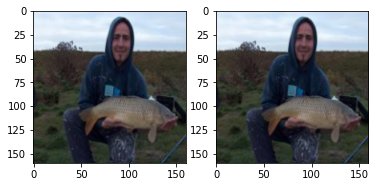

In [7]:
ds.show(0)


In [0]:
dl = DataLoader(ds, batch_size=4,shuffle=True,num_workers=2)

# 1. More features - no dropout

In [0]:
encoder = models.resnet18(pretrained=True)
encoder = nn.Sequential(*list(encoder.children())[:-2])
Pool = nn.MaxPool2d(2, 2)
Flatten = Lambda(lambda x: x.flatten(start_dim=1,end_dim=3))
Unsqz = Lambda(lambda x: x.unsqueeze(2).unsqueeze(2))
encoder = nn.Sequential(encoder,Pool,Flatten,Unsqz)

In [0]:
mdl = nn.Sequential(encoder, Lambda(lambda x: x.transpose(1,3)),
                    nn.Linear(8192,10),Lambda(lambda x: x.flatten(1,3)))

In [16]:
inputs, outs = next(iter((dl)))
mdl(inputs).shape

torch.Size([16, 10])

In [0]:
data = ImageDataBunch.from_folder(path,train='train',valid='val',bs=32,size=240).normalize(imagenet_stats)
learn = Learner(data,mdl,loss_func=nn.CrossEntropyLoss(),callback_fns=ShowGraph,metrics=[accuracy])

In [0]:
for child in learn.model.children():
    for param in child.parameters():
        param.requires_grad = False

for param in learn.model[-2].parameters():
    param.requires_grad=True

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


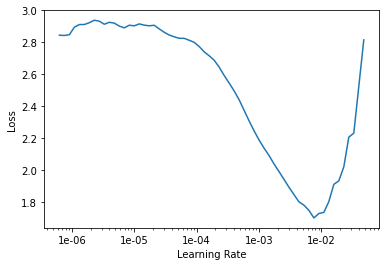

In [24]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.194070,0.179746,0.938854,00:53
1,0.313939,0.241356,0.947771,00:52
2,0.308035,0.241694,0.964076,00:52
3,0.221762,0.223328,0.966369,00:52
4,0.193286,0.250107,0.967643,00:52
5,0.161579,0.351978,0.965860,00:53
6,0.071186,0.220969,0.971210,00:52
7,0.014329,0.271472,0.967389,00:52
8,0.003985,0.236957,0.971975,00:53
9,0.007268,0.207237,0.973758,00:53


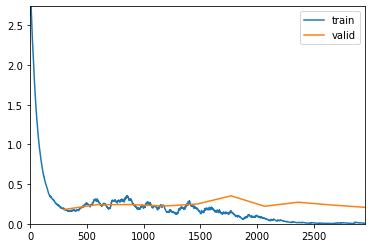

In [27]:
learn.fit_one_cycle(10,max_lr=1e-3)

# 2. More feature - with dropout

In [0]:
mdl = nn.Sequential(encoder, Lambda(lambda x: x.transpose(1,3)), nn.Dropout(p=0.2),
                    nn.Linear(8192,10),Lambda(lambda x: x.flatten(1,3)))

In [0]:
learn = Learner(data,mdl,loss_func=nn.CrossEntropyLoss(),callback_fns=ShowGraph,metrics=[accuracy])
for child in learn.model.children():
    for param in child.parameters():
        param.requires_grad = False

for param in learn.model[-2].parameters():
    param.requires_grad=True

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


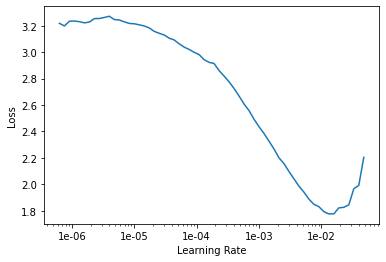

In [39]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.216752,0.130756,0.960764,00:53
1,0.249459,0.406519,0.923057,00:53
2,0.351583,0.294556,0.957452,00:53
3,0.303692,0.449845,0.951592,00:52
4,0.183386,0.363981,0.962548,00:53
5,0.119775,0.242802,0.971210,00:53
6,0.061444,0.323111,0.967134,00:53
7,0.032328,0.223048,0.973758,00:53
8,0.021088,0.195951,0.975032,00:53
9,0.014766,0.187344,0.978089,00:53


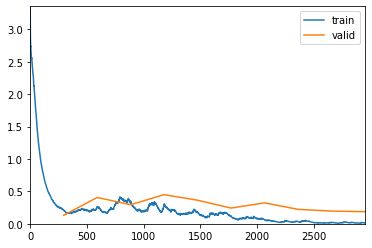

In [40]:
learn.fit_one_cycle(10,max_lr=1e-3)

# 3. More features - more dropout

In [0]:
mdl = nn.Sequential(encoder, Lambda(lambda x: x.transpose(1,3)), nn.Dropout(p=0.5),
                    nn.Linear(8192,10),Lambda(lambda x: x.flatten(1,3)))

In [0]:
learn = Learner(data,mdl,loss_func=nn.CrossEntropyLoss(),callback_fns=ShowGraph,metrics=[accuracy])
for child in learn.model.children():
    for param in child.parameters():
        param.requires_grad = False

for param in learn.model[-2].parameters():
    param.requires_grad=True

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


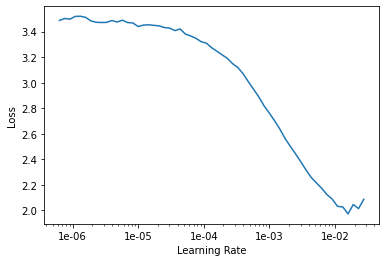

In [43]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.277990,0.146661,0.953885,00:53
1,0.272771,0.217436,0.949045,00:53
2,0.381533,0.380218,0.948790,00:53
3,0.298305,0.278523,0.965860,00:53
4,0.238984,0.344883,0.963312,00:54
5,0.239303,0.290945,0.969172,00:54
6,0.164727,0.278647,0.967898,00:54
7,0.063644,0.221165,0.969682,00:53
8,0.043838,0.212948,0.972994,00:53
9,0.061591,0.196356,0.975541,00:53


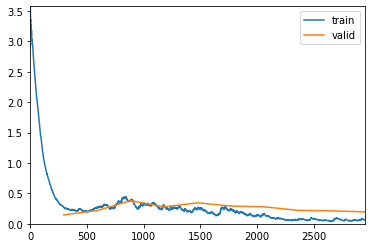

In [44]:
learn.fit_one_cycle(10,max_lr=1e-3)

# 4. Fastai default

In [0]:
default_learner = cnn_learner(data,models.resnet18,pretrained=True,metrics=[accuracy],callback_fns=ShowGraph)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


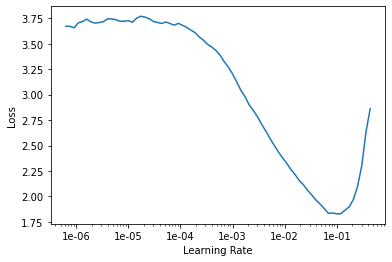

In [35]:
default_learner.lr_find()
default_learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.203320,0.114050,0.969936,00:55
1,0.428700,0.389592,0.904968,00:55
2,0.458069,0.375929,0.895287,00:55
3,0.344930,0.528504,0.852484,00:55
4,0.277342,0.264859,0.918217,00:55
5,0.210627,0.196966,0.935032,00:55
6,0.144682,0.176579,0.947516,00:55
7,0.102489,0.136499,0.957197,00:55
8,0.049493,0.118121,0.964076,00:55
9,0.056983,0.123512,0.961783,00:55


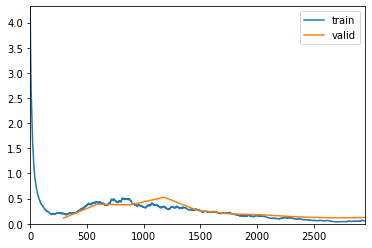

In [36]:
default_learner.fit_one_cycle(10,max_lr=1e-2)

# 5. Autoencoder

In [0]:
encoder = models.resnet18(pretrained=True)
encoder = nn.Sequential(*list(encoder.children())[:-1])
#encoder = models.resnet18(pretrained=True)
#encoder = nn.Sequential(*list(encoder.children())[:-2])
#Pool = nn.MaxPool2d(2, 2)
#Flatten = Lambda(lambda x: x.flatten(start_dim=1,end_dim=3))
#Unsqz = Lambda(lambda x: x.unsqueeze(2).unsqueeze(2))
#encoder = nn.Sequential(encoder,Pool,Flatten,Unsqz)

In [0]:
#corrections = nn.Sequential(Pool,Flatten,Unsqz)
#encoder = nn.Sequential(encoder,corrections)

In [55]:
encoder(inputs).shape

torch.Size([4, 512, 1, 1])

In [0]:
inputs,outs = next(iter(dl))

In [0]:
model = DynamicUnet(encoder, 3, img_size=(160,160),self_attention=True,blur=True,last_cross=True)

In [13]:
model(inputs).shape

torch.Size([4, 3, 160, 160])

In [0]:
data = DataBunch(dl,dl)

In [0]:
learn = Learner(data,model,loss_func=nn.MSELoss(),callback_fns=ShowGraph)

In [0]:
for child in learn.model.children():
    for params in child.parameters():
        params.requires_grad = False

for child in learn.model[1:].children():
    for params in child.parameters():
        params.requires_grad = True

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


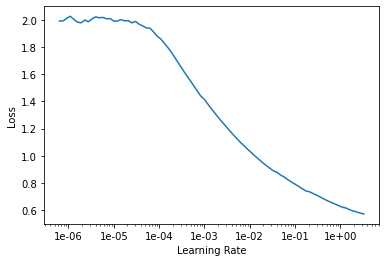

In [106]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,8414.970703,10461.953125,00:25
1,8343.476562,8927.422852,00:25
2,8219.875977,8236.166016,00:25
3,7940.198730,7835.348633,00:25
4,7626.620605,8021.262695,00:25
5,7496.974121,7637.477539,00:25
6,7321.099121,7649.793457,00:25
7,7351.541016,7593.166992,00:25
8,7251.859375,7404.351562,00:25
9,7311.170410,7512.617676,00:25


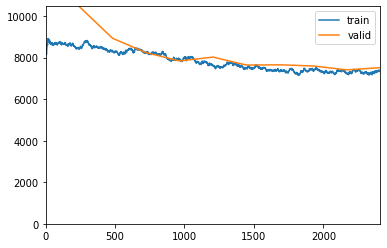

Better model found at epoch 0 with valid_loss value: 10461.953125.
Better model found at epoch 1 with valid_loss value: 8927.4228515625.
Better model found at epoch 2 with valid_loss value: 8236.166015625.
Better model found at epoch 3 with valid_loss value: 7835.3486328125.
Better model found at epoch 5 with valid_loss value: 7637.4775390625.
Better model found at epoch 7 with valid_loss value: 7593.1669921875.
Better model found at epoch 8 with valid_loss value: 7404.3515625.


In [97]:
learn.fit_one_cycle(10,max_lr=2e-2,
                    callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage-1')])

In [0]:
_ = learn.load('stage-1')

In [0]:
def show_results(learn,figsize=(10,10)):

    inputs,classes = next(iter(learn.data.valid_dl))
    learn.model.train()
    preds = learn.model(inputs)
    stds = np.array([0.229, 0.224, 0.225])
    means = np.array([0.485, 0.456, 0.406])
    #inp = (inputs[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255
    target = (classes[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255
    pred = (preds[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255

    mse = np.sum(((pred - target)**2))/(pred.shape[0]*pred.shape[1]*pred.shape[2])
    psnr = 10*np.log10(255/mse)

    print('MSE:',mse)
    print('PSNR:', psnr)


    fig = plt.figure(figsize=figsize)
    #ax0 = fig.add_subplot(131)
    #ax0.imshow(inp.astype(np.uint8))
    #ax0.title.set_text('Input')
    ax1 = fig.add_subplot(132)
    ax1.imshow(target.astype(np.uint8))
    ax1.title.set_text('Target')
    ax2 = fig.add_subplot(133)
    ax2.imshow(pred.astype(np.uint8))
    ax2.title.set_text('Prediction')

MSE: 7769.841330835018
PSNR: -14.83871969660859


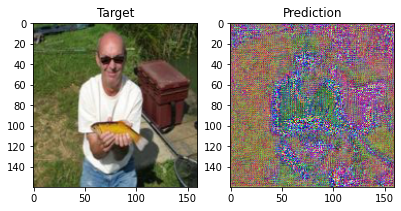

In [100]:
show_results(learn)